<a href="https://colab.research.google.com/github/klipare/10fa_az_de_kshitij_lipare/blob/main/Pru_Data_Test_Az_DE_Kshitij_Lipare.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pru Wealth Data Test

Below we will explore a mock database of customers, policies and funds that are similar to the Pru Wealth data. The first section of this notebook will test your SQL skills, the second section will test your Python skills and visualisation skills.

The database file is called Prudential_Data.db

The three tables included in this database are:
* Customer_Table
* Policy_Table
* Fund_Table

You will need to have the following packages installed in your Python environment:
* numpy
* pandas
* sqlite3

For visualization use any package of your choice (e.g., matplotlib, seaborn, plotly).

Please complete and return the test before the deadline by emailing your copy of this notebook to: Denholm.Hesse@Prudential.co.uk. If you do not know the answer to a question feel free to use Google and Stack Overflow. This is to give you the option to teach yourself a concept from the internet to address a question which you do not know the answer to, please refrain from skipping questions. The test is meant to be completed by you only.

Good luck and have fun!

In [1]:
import numpy as np
import pandas as pd
import sqlite3

# SQL test

IMPORANT: Please make sure all questions in this section are solved using SQL by only editing the content of the variable *sqlite_query*. Please do not edit the below cell:

In [2]:
# Establish DB connection
conn = sqlite3.connect('Prudential_Data.db')

Below is an example of how to query the SQLlite databse from this Jupyter notebook. Please note that SQLlite might have a slightly different syntax from the SQL you normally use. Please do not edit the below cell:

In [3]:
sqlite_query = """
SELECT COUNT(*) 
from policy_table 
"""

pd.read_sql(sqlite_query, conn)

,COUNT(*)
0,1635


The first table "Customer_Table" contains personal information about the customers. Please do not edit the below cell:

In [4]:
sqlite_query = """
SELECT * 
from Customer_Table 
limit 5
"""

pd.read_sql(sqlite_query, conn)

,index,Customer ID,Email,Gender,Age,Postcode
0,0,CO183683,NLUPPITT14@PARALLELS.COM,Male,90,None
1,1,CO314757,None,Female,90,None
2,2,CO720602,None,Female,90,None
3,3,CO34804,None,Female,90,1495-701
4,4,CO474411,None,Male,90,301288


The second table "Policy_Table" contains data relating to customer policies. The policy value is the current value of the policy. Please do not edit the below cell:

In [5]:
sqlite_query = """
SELECT * 
from Policy_Table 
limit 5
"""

pd.read_sql(sqlite_query, conn)

,index,Policy Number,Customer ID,Product Category,Product Name,Policy Value,Policy Start Date
0,0,RET100072,CO276506,RETIREMENT,RETIREMENT ACCOUNT,270033.0,2016-01-02 00:00:00
1,1,RET100931,CO831289,RETIREMENT,RETIREMENT ACCOUNT,26394.0,2016-01-04 00:00:00
2,2,RET100682,CO784249,RETIREMENT,RETIREMENT ACCOUNT,773567.0,2016-01-04 00:00:00
3,3,RET100447,CO295533,RETIREMENT,RETIREMENT ACCOUNT,35512.0,2016-01-07 00:00:00
4,4,RET100390,CO901735,RETIREMENT,RETIREMENT ACCOUNT,767580.0,2016-01-08 00:00:00


The final table "Fund_Table" contains historic data on the Policy Value (Policy_Value_Snapshot). The Policy_Value_Snapshot represents the value of the policy and the Date column is the date at which that value was recorded. The value may have changed overtime due to changes in the fund price or quanity of units the policy was invested in. Please do not edit the below cell:

In [6]:
sqlite_query = """
SELECT 
*
from Fund_Table
limit 5

"""

pd.read_sql(sqlite_query, conn)

,index,Policy Number,Customer ID,Date,Product Category,Product Name,Policy_Value_Snapshot
0,0,ANN1221,CO408564,2009-10-31 00:00:00,ANNUITY,STANDARD ANNUITY,None
1,1,ANN1221,CO408564,2009-11-30 00:00:00,ANNUITY,STANDARD ANNUITY,None
2,2,ANN1221,CO408564,2009-12-31 00:00:00,ANNUITY,STANDARD ANNUITY,None
3,3,ANN1221,CO408564,2010-01-31 00:00:00,ANNUITY,STANDARD ANNUITY,None
4,4,ANN1221,CO408564,2010-02-28 00:00:00,ANNUITY,STANDARD ANNUITY,None


If a question requires additional explanation for your answer, please add additional cells below the code. 

## Q1: What is the current average policy value split by each product name? 

In [7]:
sqlite_query = """
-- Get Current Policy Date
WITH Policy_Current_Date AS (SELECT
[Policy Number]
, max([Date]) AS [Current Date]
FROM [Fund_Table]
GROUP BY [Policy Number]
)

SELECT
f.[Product Name]
, ROUND(AVG(IFNULL(p.[Policy Value], 0)),2) AS [Current Average Policy Value]
FROM [Fund_Table] f
INNER JOIN [Policy_Table] p
ON p.[Policy Number] = f.[Policy Number]
INNER JOIN Policy_Current_Date c
ON c.[Current Date] = f.[Date]
GROUP BY f.[Product Name]
ORDER BY f.[Product Name];
"""

pd.read_sql(sqlite_query, conn)

,Product Name,Current Average Policy Value
0,CORPORATE MEMBERSHIP,5697.29
1,FOCUSSED ISA,5746.34
2,NHS PENSION,5241.50
3,PRU BOND,4516.39
4,PRUDENTIAL INVESTMENT PLAN,5084.52
5,PRUDENTIAL ISA,5161.14
6,RETIREMENT ACCOUNT,504964.96
7,SIPP,5335.84
8,STANDARD ANNUITY,0.00


## Q2: How many customers opened a new policy in Q1 2017 who already had an existing pension product? 

In [8]:
# Assuming required customers can have any category of policies opened in the Quarter-1 of Calendar Year 2017
sqlite_query = """
-- Get Customers with existing Pension Product before Quarter-1 of Calendar Year 2017
WITH Existing_Pension_Customers AS (
SELECT DISTINCT
[Customer ID]
FROM [Policy_Table]
WHERE UPPER([Product Category]) = "PENSION"
AND [Policy Start Date] < "2017-01-01 00:00:00"
ORDER BY [Policy Start Date] DESC
)

SELECT
COUNT(DISTINCT p.[Customer ID]) AS [Existing Pension Customers]
FROM [Policy_Table] p
INNER JOIN [Existing_Pension_Customers] e
ON e.[Customer ID] = p.[Customer ID]
AND p.[Policy Start Date] BETWEEN "2017-01-01 00:00:00" AND "2017-04-01 00:00:00";
"""
pd.read_sql(sqlite_query, conn)

,Existing Pension Customers
0,35


## Q3: What was the customer ID that had the biggest difference in policy value between its earliest and latest date (for any product) ?

In [9]:
# Assuming the difference could be either positive or negative, hence taking the magnitude in consideration
sqlite_query = """
-- Get Policy Start Date and Latest Date
WITH [Policy_Date_Bracket] AS (
SELECT
[Policy Number]
, MIN([Date]) AS [Policy Start Date]
, MAX([Date]) AS [Policy Latest Date]
FROM [Fund_Table] f
GROUP BY [Policy Number]
)
-- Get Policy Value at Start Date
, [Policy_Start_Value] AS (
SELECT
f.[Policy Number]
, IFNULL(f.[Policy_Value_Snapshot],0) AS [Policy Value]
FROM [Fund_Table] f
INNER JOIN [Policy_Date_Bracket] d
ON d.[Policy Number]= f.[Policy Number]
AND d.[Policy Start Date] = f.[Date]
INNER JOIN [Policy_Table] p
ON p.[Policy Number] = f.[Policy Number]
)
-- Get Policy Value at Latest Date
, [Policy_Latest_Value] AS (
SELECT
f.[Policy Number]
, IFNULL(f.[Policy_Value_Snapshot],0) AS [Policy Value]
FROM [Fund_Table] f
INNER JOIN [Policy_Date_Bracket] d
ON d.[Policy Number]= f.[Policy Number]
AND d.[Policy Latest Date] = f.[Date]
INNER JOIN [Policy_Table] p
ON p.[Policy Number] = f.[Policy Number]
)
-- Get Policy Value Difference
SELECT
p.[Customer ID]
, ROUND(ABS(l.[Policy Value] - s.[Policy Value]),2) AS [Policy Value Difference]
FROM [Policy_Table] p
INNER JOIN [Policy_Latest_Value] l
ON l.[Policy Number] = p.[Policy Number] 
INNER JOIN [Policy_Start_Value] s
ON s.[Policy Number] = p.[Policy Number]
ORDER BY 2 DESC
LIMIT 1;
"""

pd.read_sql(sqlite_query, conn)

,Customer ID,Policy Value Difference
0,CO401070,943283.5


# Python Test

Same data, but now let's have some fun in python. Please do not use SQL for this part of the exercise. 

Feel free to add more cells of code or text

In [10]:
Customer_Table = pd.read_sql('SELECT * FROM Customer_Table', conn)
Policy_Table = pd.read_sql('SELECT * FROM Policy_Table', conn)
Fund_Table = pd.read_sql('SELECT * FROM Fund_Table', conn)

## Q4: Produce a list of customers which have an invalid email address. What do you notice about these customers? ##

Feel free to use any packages of your choice

In [11]:
#Insert your answer below: 
# import supporting modules
import re
import matplotlib.pyplot as plt
import seaborn as sns

# Regular expression for validating an Email 
#regex = '^[a-z0-9]+[\._]?[a-z0-9]+[@]\w+[.]\w{2,3}$'
regex = '^[a-z0-9]+[\._]?[a-z0-9]+[@]\w+[.]\w+$'

In [12]:
# Define a function for validating an Email
def check(email):
    # Validate provided email through defined regex
    if(re.search(regex, email)):
        flag = "Y"
    else:
        flag = "N"
    return flag

In [13]:
# Create a DataFrame from the base Customer Table DataFrame
Customer_Email_Table = Customer_Table.fillna("None")
Customer_Email_Table["IsValidEmail"] = ""
for ind in Customer_Email_Table.index:
    # Check for each customer whether the email provided is valid or not
    check_valid_flag = check(Customer_Email_Table["Email"][ind].lower())
    # Update the IsValidEmail flag
    Customer_Email_Table.loc[ind,"IsValidEmail"] = check_valid_flag

In [14]:
# Creating the Merged Dataset for Exploratory Analysis

# Dropping unnecessary columns from original Datasets
Customer_Email_Table_1 = Customer_Email_Table.drop(["index"],
                                                   axis=1)
Policy_Table_1 = Policy_Table.drop(["index"],
                                   axis=1)
Fund_Table_1 = Fund_Table.drop(["index", "Product Category", "Product Name", "Customer ID"],
                               axis=1)

# MErging Datasets
df_merge_temp_1 = pd.merge(Customer_Email_Table_1, Policy_Table_1,
                         on="Customer ID")
df_merge_temp_2 = pd.merge(df_merge_temp_1, Fund_Table_1,
                          on="Policy Number")

# Filling Nulls
df_merge_nonull = df_merge_temp_2.fillna(0)

# Creating Age Brackets
bins = [18, 30, 40, 50, 60, 70, 120]
labels = ['18-29', '30-39', '40-49', '50-59', '60-69', '70+']
df_merge_nonull["Age Bracket"] = ""
df_merge_nonull["Age Bracket"] = pd.cut(df_merge_nonull.Age, bins, labels = labels, include_lowest = True)

# Formatting the Final Merged Dataset
df_merge_final = df_merge_nonull
df_merge_final['Year'] = pd.to_datetime(df_merge_final['Date']).dt.to_period('Y')
df_merge_final['Year_Month'] = pd.to_datetime(df_merge_final['Date']).dt.to_period('M')
df_merge_final = df_merge_final.sort_values(by = ["Date", "Policy Number", "Customer ID", "Product Category"])

# Describing the Formatted Dataset
display(df_merge_final.head(5))
df_merge_final.info()
df_merge_final.describe(include="all")

,Customer ID,Email,Gender,Age,Postcode,IsValidEmail,Policy Number,Product Category,Product Name,Policy Value,Policy Start Date,Date,Policy_Value_Snapshot,Age Bracket,Year,Year_Month
30890,CO580314,OBUCKBERRY1E@LIST-MANAGE.COM,Female,65,None,N,B1214,BOND,PRUDENTIAL INVESTMENT PLAN,2423.0,2009-07-08 00:00:00,2009-07-31 00:00:00,24623.260870,60-69,2009,2009-07
68500,CO928817,CDAGNANQG@AUDA.ORG.AU,Male,42,79400-000,N,B8171,BOND,PRU BOND,3409.0,2009-07-23 00:00:00,2009-07-31 00:00:00,24631.834783,40-49,2009,2009-07
67209,CO268915,LJAYNED0@OMNITURE.COM,Female,42,None,Y,B8448,BOND,PRUDENTIAL INVESTMENT PLAN,6981.0,2009-07-11 00:00:00,2009-07-31 00:00:00,24662.895652,40-49,2009,2009-07
51573,CO322312,EHAMMERSON1Y@NATIONALGEOGRAPHIC.COM,Male,56,4935-621,Y,ISA4209,ISA,FOCUSSED ISA,7131.0,2009-07-22 00:00:00,2009-07-31 00:00:00,24664.200000,50-59,2009,2009-07
22560,CO88500,TPLEASANCE1H@USNEWS.COM,Female,69,None,Y,ISA6414,ISA,PRUDENTIAL ISA,5058.0,2009-07-14 00:00:00,2009-07-31 00:00:00,24646.173913,60-69,2009,2009-07


<class 'pandas.core.frame.DataFrame'>
Int64Index: 72121 entries, 30890 to 32927
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype        
---  ------                 --------------  -----        
 0   Customer ID            72121 non-null  object       
 1   Email                  72121 non-null  object       
 2   Gender                 72121 non-null  object       
 3   Age                    72121 non-null  int64        
 4   Postcode               72121 non-null  object       
 5   IsValidEmail           72121 non-null  object       
 6   Policy Number          72121 non-null  object       
 7   Product Category       72121 non-null  object       
 8   Product Name           72121 non-null  object       
 9   Policy Value           72121 non-null  float64      
 10  Policy Start Date      72121 non-null  object       
 11  Date                   72121 non-null  object       
 12  Policy_Value_Snapshot  72121 non-null  float64      
 13  Age Bracket 

,Customer ID,Email,Gender,Age,Postcode,IsValidEmail,Policy Number,Product Category,Product Name,Policy Value,Policy Start Date,Date,Policy_Value_Snapshot,Age Bracket,Year,Year_Month
count,72121,72121,72121,72121.000000,72121,72121,72121,72121,72121,72121.000000,72121,72121,72121.000000,72121,72121,72121
unique,999,951,2,NaN,456,2,1635,5,9,NaN,1206,115,NaN,6,11,115
top,CO88500,None,Female,NaN,None,Y,PXC4966,RETIREMENT,RETIREMENT ACCOUNT,NaN,2009-08-03 00:00:00,2019-01-31 00:00:00,NaN,60-69,2018,2019-01
freq,152,3285,36132,NaN,39100,61900,115,19321,19321,NaN,456,1635,NaN,24524,17811,1635
mean,NaN,NaN,NaN,63.227423,NaN,NaN,NaN,NaN,NaN,136404.583464,NaN,NaN,82119.878641,NaN,NaN,NaN
std,NaN,NaN,NaN,13.823338,NaN,NaN,NaN,NaN,NaN,265423.541933,NaN,NaN,163308.754318,NaN,NaN,NaN
min,NaN,NaN,NaN,20.000000,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,0.000000,NaN,NaN,NaN
25%,NaN,NaN,NaN,53.000000,NaN,NaN,NaN,NaN,NaN,2120.000000,NaN,NaN,9033.733333,NaN,NaN,NaN
50%,NaN,NaN,NaN,64.000000,NaN,NaN,NaN,NaN,NaN,6384.000000,NaN,NaN,17110.635514,NaN,NaN,NaN
75%,NaN,NaN,NaN,71.000000,NaN,NaN,NaN,NaN,NaN,58068.000000,NaN,NaN,33761.151515,NaN,NaN,NaN


In [15]:
# Analyze the Customers with Valid Email Addresses
df_merge_final_y = df_merge_final[df_merge_final["IsValidEmail"] == "Y"]
#df_merge_final_y.Email.unique()

In [16]:
# Analyze the Customers with Invalid Email Addresses
df_merge_final_n = df_merge_final[df_merge_final["IsValidEmail"] == "N"]
#df_merge_final_n.Email.unique()

In [17]:
# Finding Customers who requested for Follow up, None and Incorrect emails
df_merge_final_followup = df_merge_final_n[df_merge_final["Email"] == "CUSTOMER TO FOLLOW UP"]
df_merge_final_none = df_merge_final_n[df_merge_final["Email"] == "None"]
df_merge_final_invalid = df_merge_final_n[(df_merge_final["Email"] != "CUSTOMER TO FOLLOW UP") & (df_merge_final["Email"] != "None")]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


[Text(0.5, 1.0, 'Customers with No Email by Product Category')]

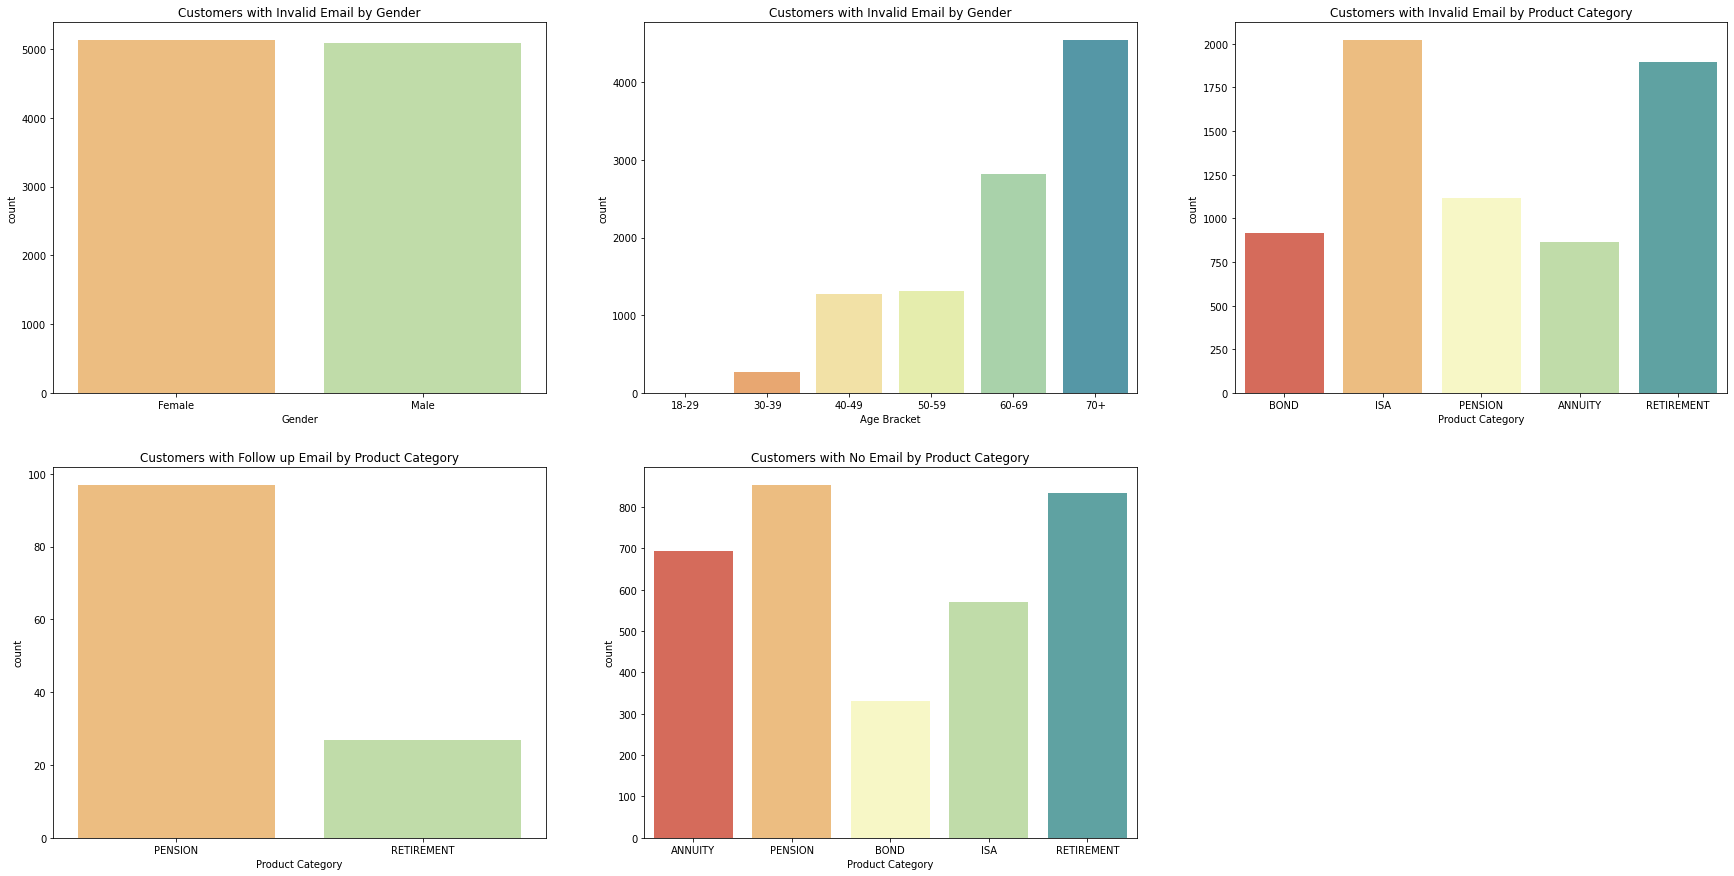

In [18]:
# Distribution of Customers by Gender
fig = plt.figure(figsize = (30,15))
ax1 = fig.add_subplot(2,3,1)
sns.countplot(x=df_merge_final_n["Gender"],
              palette='Spectral',
              ax=ax1).set(title='Customers with Invalid Email by Gender')

# Distribution of Customers by Age
ax2 = fig.add_subplot(2,3,2)
sns.countplot(x=df_merge_final_n["Age Bracket"],
              palette='Spectral',
              ax=ax2).set(title='Customers with Invalid Email by Gender')

# Distribution of Customers by Product Category
ax3 = fig.add_subplot(2,3,3)
sns.countplot(x=df_merge_final_invalid["Product Category"],
              palette='Spectral',
              ax=ax3).set(title='Customers with Invalid Email by Product Category')

# Distribution of Customers by Follow Up
ax4 = fig.add_subplot(2,3,4)
sns.countplot(x=df_merge_final_followup["Product Category"],
              palette='Spectral',
              ax=ax4).set(title='Customers with Follow up Email by Product Category')

# Distribution of Customers by No Email
ax5 = fig.add_subplot(2,3,5)
sns.countplot(x=df_merge_final_none["Product Category"],
              palette='Spectral',
              ax=ax5).set(title='Customers with No Email by Product Category')


## A4: Observations from the data.
- The Customers with Invalid email address are distributed almost equally on the basis of Gender.
- Higher the Age Bracket, Higher is the chance that customers might give an invalid email address
- Retirement, ISA & Pension product Categories observe the top 3 bulk of invalid email address aongst its customers
- Customers who have been tagged for follow up on Invalid Email address are highest in Pension Product Category followed by Retirement

## Q5: The Managing Director of Pru Wealth needs to see how policy value differs between other variables in the database (e.g. customer demographics) . They don't have time to read a report, so have asked for a cool visualisation that tells a story.

Visualise something cool, tell us a story! You can use packages like Matplotlib, Seaborn or Plotly.Tell us why you chose to visualise the data in this way and how it can be used from a business perspective.


In [69]:
# Analyze the Data for Current Year
df_curr_year = df_merge_final[df_merge_final["Year"] == "2019"]
df_curr_year_by_pc = df_curr_year.groupby(by=["Product Category"]).sum(["Policy value"])
#df_curr_year_by_pc
df_curr_year

,Customer ID,Email,Gender,Age,Postcode,IsValidEmail,Policy Number,Product Category,Product Name,Policy Value,Policy Start Date,Date,Policy_Value_Snapshot,Age Bracket,Year,Year_Month
32329,CO408564,EDAWLTREY8Q@NETSCAPE.COM,Female,65,None,Y,ANN1221,ANNUITY,STANDARD ANNUITY,0.0,2009-10-20 00:00:00,2019-01-31 00:00:00,0.0,60-69,2019,2019-01
39745,CO125958,DLAINTONGO@SFGATE.COM,Male,64,133 41,Y,ANN1225,ANNUITY,STANDARD ANNUITY,0.0,2013-05-05 00:00:00,2019-01-31 00:00:00,0.0,60-69,2019,2019-01
23528,CO210415,CJAGGSIT@OMNITURE.COM,Male,69,8411,Y,ANN1372,ANNUITY,STANDARD ANNUITY,0.0,2009-08-20 00:00:00,2019-01-31 00:00:00,0.0,60-69,2019,2019-01
15734,CO545536,VPEGGSK3@@@SPRINGER.COM,Male,74,46100-000,N,ANN1389,ANNUITY,STANDARD ANNUITY,0.0,2013-05-13 00:00:00,2019-01-31 00:00:00,0.0,70+,2019,2019-01
4489,CO745114,HPUCKEREI@MIT.EDU,Male,86,None,Y,ANN1426,ANNUITY,STANDARD ANNUITY,0.0,2013-09-08 00:00:00,2019-01-31 00:00:00,0.0,70+,2019,2019-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63718,CO415921,CGILDERRM@REVERBNATION.COM,Female,47,None,Y,RET100995,RETIREMENT,RETIREMENT ACCOUNT,804489.0,2017-07-03 00:00:00,2019-01-31 00:00:00,804489.0,40-49,2019,2019-01
12167,CO643882,LOKEENANRN@EUROPA.EU,Male,77,17209 CEDEX,Y,RET100996,RETIREMENT,RETIREMENT ACCOUNT,890950.0,2017-04-30 00:00:00,2019-01-31 00:00:00,890950.0,70+,2019,2019-01
24963,CO795420,.,Female,68,680011,N,RET100997,RETIREMENT,RETIREMENT ACCOUNT,49384.0,2017-12-11 00:00:00,2019-01-31 00:00:00,49384.0,60-69,2019,2019-01
32092,CO213842,THYATTRP@FASTCOMPANY.COM,Male,65,None,Y,RET100998,RETIREMENT,RETIREMENT ACCOUNT,569818.0,2018-03-27 00:00:00,2019-01-31 00:00:00,569818.0,60-69,2019,2019-01


In [34]:
# Analyze the Data for Previous Year
df_prev_year = df_merge_final[df_merge_final["Year"] == "2018"]
df_prev_year_by_pc = df_prev_year.groupby(by=["Product Category"]).sum(["Policy value"])
#df_prev_year_by_pc

,Age,Policy Value,Policy_Value_Snapshot
Product Category,,,
ANNUITY,93312,0.000000e+00,0.000000e+00
BOND,118008,9.238008e+06,1.240415e+07
ISA,138360,1.234255e+07,1.584761e+07
PENSION,132780,1.103570e+07,1.435912e+07
RETIREMENT,641064,5.115996e+09,3.508388e+09


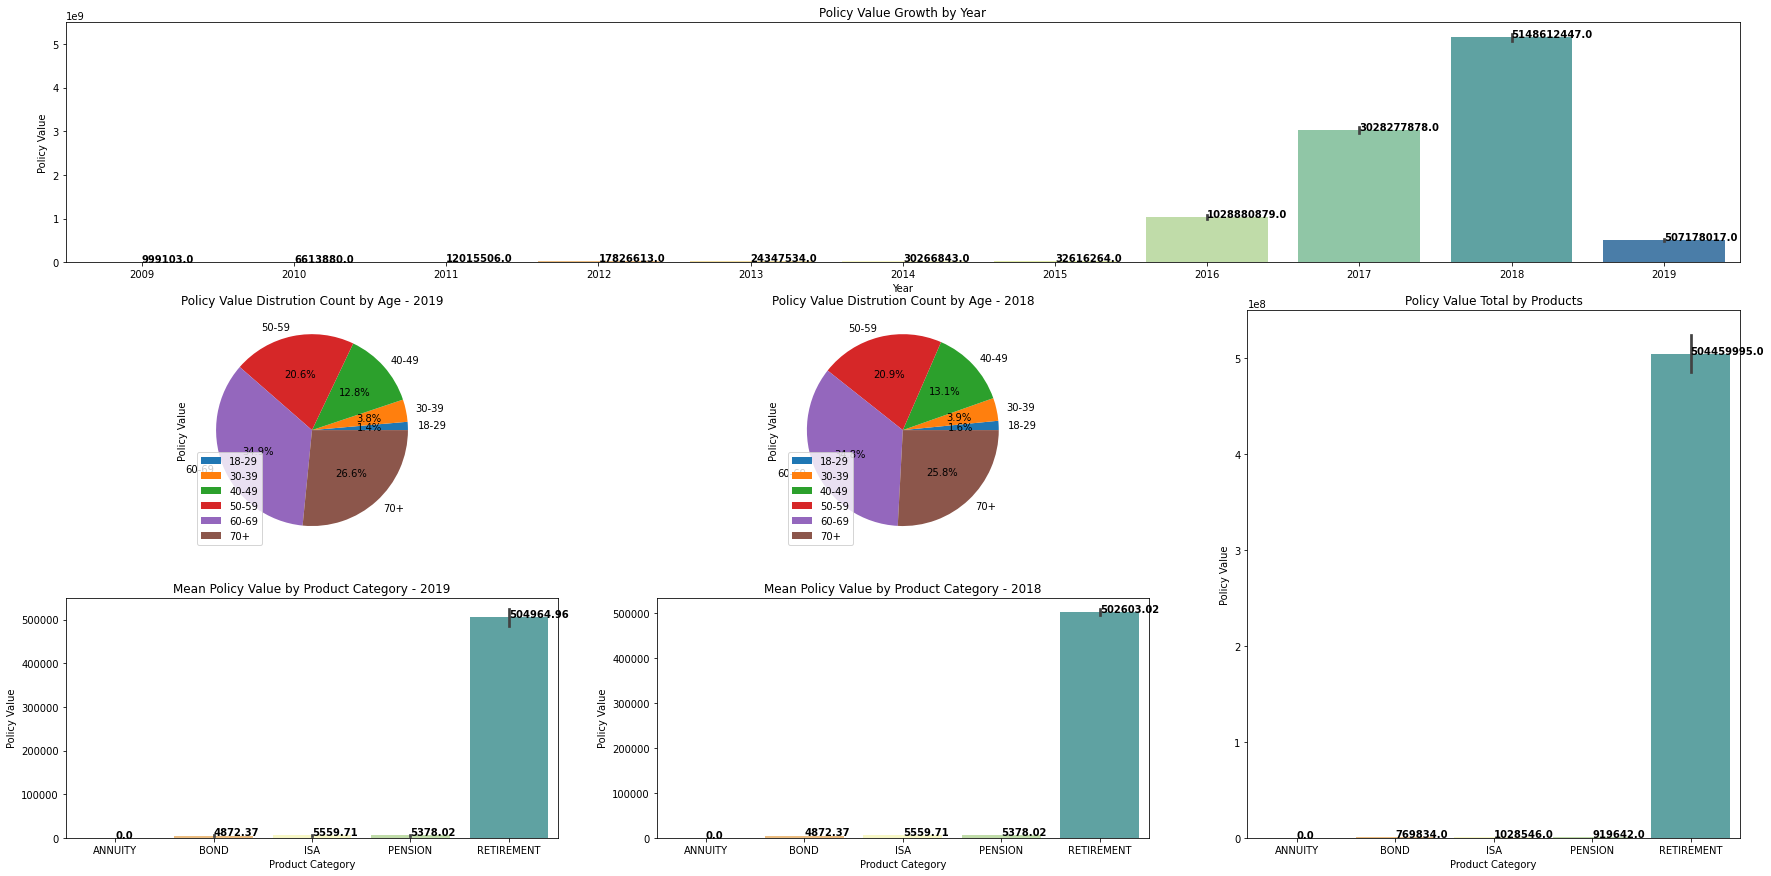

In [70]:
# Set Plot Area and Chart Placement
fig = plt.figure(figsize = (30,15))
ax0 = plt.subplot2grid(shape=(3, 3), loc=(0, 0), colspan=3) 
ax1 = plt.subplot2grid(shape=(3, 3), loc=(1, 0), colspan=1) 
ax2 = plt.subplot2grid(shape=(3, 3), loc=(1, 1), colspan=1) 
ax3 = plt.subplot2grid(shape=(3, 3), loc=(2, 0), colspan=1) 
ax4 = plt.subplot2grid(shape=(3, 3), loc=(2, 1), colspan=1) 
ax5 = plt.subplot2grid(shape=(3, 3), loc=(1, 2), colspan=1, rowspan=2) 

# Policy Value Growth over years
sns.barplot(x=df_merge_final["Year"],
            y=df_merge_final["Policy Value"],
            palette='Spectral',
            estimator=sum,
            ax=ax0).set(title='Policy Value Growth by Year')

for rect in ax0.patches:
    ax0.text (rect.get_x() + rect.get_width() / 2,rect.get_height(), round(rect.get_height(),2), weight='bold' )

# Pie Chart for Age Bracket Policy Value of Current Year
df_curr_year_pie_ageb = df_curr_year.groupby(by=["Age Bracket"]).sum("Policy Value")
df_curr_year_pie_ageb.plot.pie(y="Policy Value",
                               title="Policy Value Distrution Count by Age - 2019",
                               autopct="%.1f%%",
                               ax=ax1)

# Pie Chart for Age Bracket Policy Value of Previous Year
df_prev_year_pie_ageb = df_prev_year.groupby(by=["Age Bracket"]).sum("Policy Value")
df_prev_year_pie_ageb.plot.pie(y="Policy Value",
                               title="Policy Value Distrution Count by Age - 2018",
                               autopct="%.1f%%",
                               ax=ax2)

# Mean Policy Value by Product Category of Current Year
sns.barplot(x=df_curr_year["Product Category"],
            y=df_curr_year["Policy Value"],
            palette='Spectral',
            ax=ax3).set(title='Mean Policy Value by Product Category - 2019')

for rect in ax3.patches:
    ax3.text (rect.get_x() + rect.get_width() / 2,rect.get_height(), round(rect.get_height(),2), weight='bold' )

# Mean Policy Value by Product Category of Previous Year
sns.barplot(x=df_prev_year["Product Category"],
            y=df_prev_year["Policy Value"],
            palette='Spectral',
            ax=ax4).set(title='Mean Policy Value by Product Category - 2018')

for rect in ax4.patches:
    ax4.text (rect.get_x() + rect.get_width() / 2,rect.get_height(), round(rect.get_height(),2), weight='bold' )

# Total of Policy Value by Product Category Current Year
sns.barplot(x=df_curr_year["Product Category"],
            y=df_curr_year["Policy Value"],
            palette='Spectral',
            estimator=sum,
            ax=ax5).set(title='Policy Value Total by Products')

for rect in ax5.patches:
    ax5.text (rect.get_x() + rect.get_width() / 2,rect.get_height(), round(rect.get_height(),2), weight='bold' )


## A5: Chart Analysis
- The mean Policy Value across all Product Categories has remained same with marginal improvement in Retirement Product since previous year
- The Customers from Retirement Age brackets above 60 years garner about 60% of the Mean Policy Value for current and previous years
- The young Customers below 40 years account to roughly 5% of the Mean Policy Value for current and previous years and has declined marginally since last year 